In [42]:
import numpy as np
import matplotlib.pyplot as plt

In [117]:
n_neurons = 64
n_steps = 10000
n_driven_current = 2
n_recorded_neuron = 8

In [118]:
"""generate weights"""
np.random.seed(123)
weight_sigma = 1.
weights = np.random.normal(-0.5, weight_sigma, (n_neurons, n_neurons))/np.sqrt(n_neurons)
np.fill_diagonal(weights, 0.)
weights.tofile('weights.bin')

In [119]:
"""generate inital neuron state"""
vs = np.zeros((n_neurons, 1))
gates = np.random.uniform(0, 1, (n_neurons, 3))
states = np.concatenate((vs, gates), axis=-1)
states.tofile("initial_states.bin")

In [120]:
"""generate driving currents"""
driving_currents = np.ones((2, n_steps))*100 # for simplicity, just use a constant current. 
# driving_currents[0, :] = np.arange(n_steps)
driving_currents.tofile("driving_currents.bin")

In [121]:
"""get recorded data"""
voltage_record = np.fromfile("voltage_record.bin", dtype=np.float64).reshape((n_recorded_neuron, n_steps))

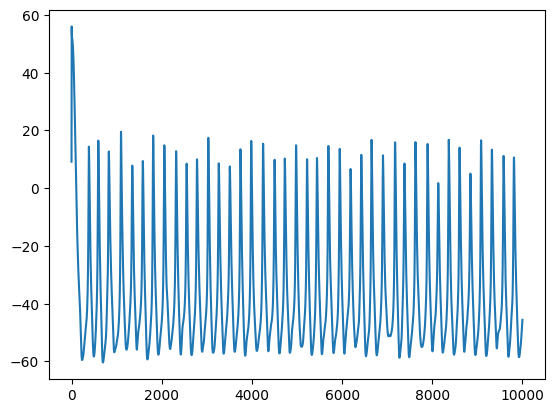

In [124]:
plt.plot(voltage_record[1, :10000])